## 1. Import dataset & data preprocess

See details in utils/data_preprocess.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Example input images:


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


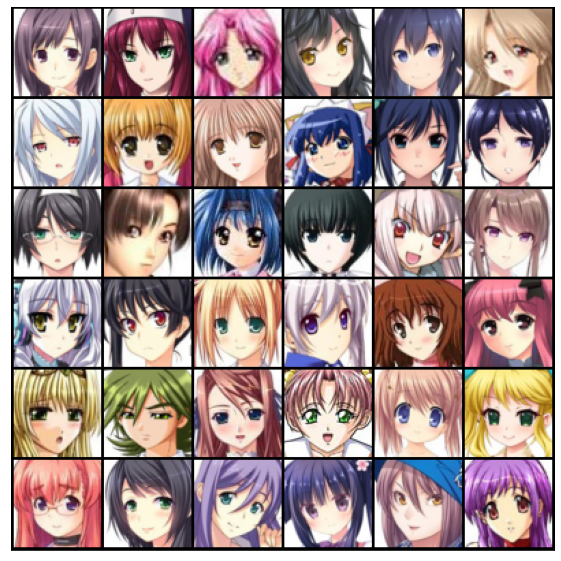

In [2]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/data_preprocess.ipynb

## 2. Load DCGAN base architecture


In [3]:
!pip install torchsummary
import torch.nn as nn
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Inputs for the run:
# Number of workers for dataloader
workers = 2
batch_size = 128
image_size = 64
nc = 3    # Number of channels in the training images. For color images this is 3
latent_size = 128  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
epochs = 50
lr = 0.0002
betas = (0.5, 0.999)
ngpu = 1  # Number of GPUs available. Use 0 for CPU mode.
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # in: latent_size x 1 x 1
            #512 = ngf * 8
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [7]:
generator = Generator()
discriminator = Discriminator()

torch.Size([128, 3, 64, 64])


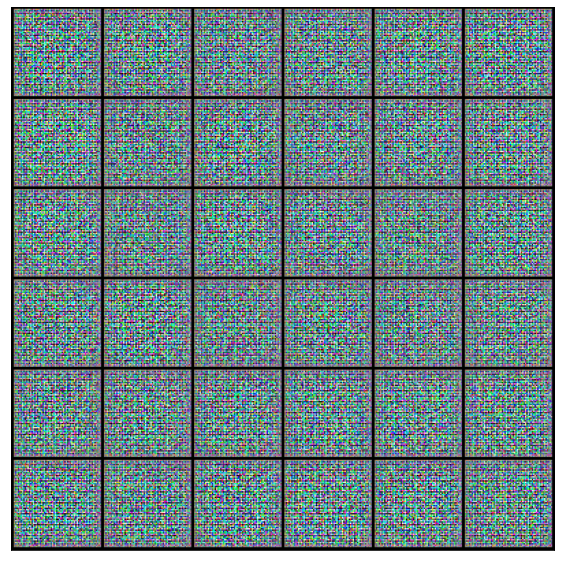

In [9]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [10]:
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

In [11]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of generator:' + color.END)

print(summary(generator,(latent_size,1,1)))

Architecture of generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
            

In [12]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of discriminator:' + color.END)
print(summary(discriminator,(3,64,64)))

Architecture of discriminator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
        

## Train DCGAN


In [13]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torch.autograd import Variable

In [14]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [15]:
sample_dir = 'generated_dcgan/images'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = '{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [16]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving 0000.png


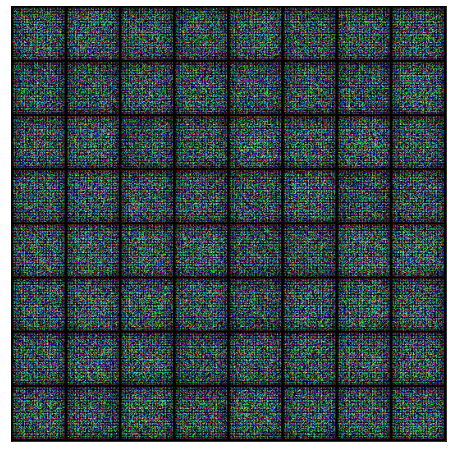

In [17]:
save_samples(0, fixed_latent)

In [18]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            # Train discriminator
            # Clear discriminator gradients
            optimizer_D.zero_grad()

            # Pass real images through discriminator
            real_preds = discriminator(real_images)
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)
            fake_preds = discriminator(fake_images)

            real_targets = torch.ones(real_images.size(0), 1, device=device)
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)

            real_loss = F.binary_cross_entropy(real_preds, real_targets)
            real_score = torch.mean(real_preds).item()
            fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
            fake_score = torch.mean(fake_preds).item()

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()

            optimizer_D.step()
            loss_d = loss_d.item()


            # Clear generator gradients
            optimizer_G.zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)
            
            # Try to fool the discriminator
            preds = discriminator(fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = F.binary_cross_entropy(preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer_G.step()

            loss_g = loss_g.item()
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [19]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 2.6972, loss_d: 0.4036, real_score: 0.7565, fake_score: 0.0769
Saving 0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 3.9076, loss_d: 0.3574, real_score: 0.7943, fake_score: 0.0644
Saving 0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 7.4765, loss_d: 0.6855, real_score: 0.9121, fake_score: 0.3968
Saving 0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 6.8008, loss_d: 0.3717, real_score: 0.9606, fake_score: 0.2378
Saving 0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 12.2513, loss_d: 0.5160, real_score: 0.9968, fake_score: 0.3364
Saving 0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 6.1489, loss_d: 0.1255, real_score: 0.9831, fake_score: 0.0930
Saving 0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 6.8626, loss_d: 0.1461, real_score: 0.9045, fake_score: 0.0019
Saving 0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 7.5453, loss_d: 0.1171, real_score: 0.9755, fake_score: 0.0828
Saving 0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 4.9103, loss_d: 0.2709, real_score: 0.8298, fake_score: 0.0084
Saving 0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 4.8986, loss_d: 0.1330, real_score: 0.9149, fake_score: 0.0156
Saving 0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 4.5231, loss_d: 0.1422, real_score: 0.9083, fake_score: 0.0192
Saving 0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 6.6776, loss_d: 0.1328, real_score: 0.9405, fake_score: 0.0575
Saving 0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 5.4922, loss_d: 0.2031, real_score: 0.9055, fake_score: 0.0769
Saving 0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 6.2088, loss_d: 0.0499, real_score: 0.9978, fake_score: 0.0420
Saving 0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 3.2564, loss_d: 0.2732, real_score: 0.8374, fake_score: 0.0066
Saving 0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 9.1985, loss_d: 0.1217, real_score: 0.9809, fake_score: 0.0933
Saving 0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 4.9501, loss_d: 0.1096, real_score: 0.9517, fake_score: 0.0488
Saving 0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 6.5407, loss_d: 0.0905, real_score: 0.9568, fake_score: 0.0394
Saving 0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 8.1656, loss_d: 0.0676, real_score: 0.9944, fake_score: 0.0573
Saving 0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 7.3156, loss_d: 0.0536, real_score: 0.9898, fake_score: 0.0406
Saving 0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 9.1587, loss_d: 0.0345, real_score: 0.9710, fake_score: 0.0012
Saving 0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 7.3066, loss_d: 0.0649, real_score: 0.9715, fake_score: 0.0290
Saving 0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 6.7295, loss_d: 0.0515, real_score: 0.9873, fake_score: 0.0308
Saving 0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 6.2470, loss_d: 0.0268, real_score: 0.9888, fake_score: 0.0138
Saving 0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 6.5676, loss_d: 0.0290, real_score: 0.9841, fake_score: 0.0108
Saving 0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 8.1344, loss_d: 0.0216, real_score: 0.9984, fake_score: 0.0195
Saving 0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 3.1739, loss_d: 0.2591, real_score: 0.8233, fake_score: 0.0020
Saving 0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 6.6893, loss_d: 0.0298, real_score: 0.9753, fake_score: 0.0018
Saving 0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 6.9670, loss_d: 0.0402, real_score: 0.9689, fake_score: 0.0023
Saving 0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 10.4547, loss_d: 0.1405, real_score: 0.9808, fake_score: 0.1052
Saving 0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 5.9196, loss_d: 0.0705, real_score: 0.9685, fake_score: 0.0283
Saving 0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 14.9905, loss_d: 0.0397, real_score: 0.9721, fake_score: 0.0003
Saving 0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 7.4530, loss_d: 0.0288, real_score: 0.9759, fake_score: 0.0024
Saving 0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 16.4303, loss_d: 0.0048, real_score: 0.9988, fake_score: 0.0035
Saving 0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 11.5284, loss_d: 0.0136, real_score: 0.9958, fake_score: 0.0091
Saving 0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 28.8813, loss_d: 0.4032, real_score: 0.9989, fake_score: 0.2594
Saving 0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 8.7817, loss_d: 0.0842, real_score: 0.9967, fake_score: 0.0749
Saving 0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 5.5866, loss_d: 0.0173, real_score: 0.9966, fake_score: 0.0137
Saving 0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 22.9439, loss_d: 0.0074, real_score: 0.9941, fake_score: 0.0011
Saving 0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 6.7095, loss_d: 0.0288, real_score: 0.9936, fake_score: 0.0209
Saving 0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 7.1940, loss_d: 0.0225, real_score: 0.9889, fake_score: 0.0091
Saving 0041.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 5.3430, loss_d: 0.0313, real_score: 0.9799, fake_score: 0.0071
Saving 0042.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 3.6317, loss_d: 0.1283, real_score: 0.9455, fake_score: 0.0147
Saving 0043.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 8.2176, loss_d: 0.0598, real_score: 0.9970, fake_score: 0.0501
Saving 0044.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 5.6545, loss_d: 0.0338, real_score: 0.9848, fake_score: 0.0156
Saving 0045.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 6.5459, loss_d: 0.0283, real_score: 0.9811, fake_score: 0.0073
Saving 0046.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 6.1498, loss_d: 0.0499, real_score: 0.9572, fake_score: 0.0018
Saving 0047.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 22.0866, loss_d: 0.5692, real_score: 1.0000, fake_score: 0.2806
Saving 0048.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 7.3602, loss_d: 0.0430, real_score: 0.9873, fake_score: 0.0204
Saving 0049.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 9.2935, loss_d: 0.0563, real_score: 0.9986, fake_score: 0.0511
Saving 0050.png


In [20]:
losses_g_dcgan, losses_d_dcgan, real_scores_dcgan, fake_scores_dcgan = history

In [21]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

## Output visualization & evaluation


In [22]:
output_dir = '/content/generated_dcgan/images'

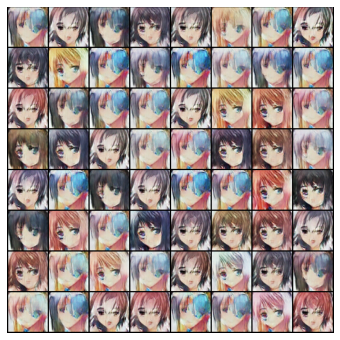

In [23]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/visualize_outputs.ipynb

In [24]:
HTML(ani.to_jshtml())

In [ ]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/eval.ipynb

In [ ]:
path = '/content/generated_dcgan'

!cp -r '/content/generated_dcgan' '/content/drive/MyDrive/ML_notes/301_Final_proj'